In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

## Problem 1

In [2]:
from load_helper import ast_helper, graph_helper

### Importance sampling
10k in 3.34s implies 1.7e6 in 10 min

In [3]:
import parse
import importance_sampling
import importlib
importlib.reload(parse)

<module 'parse' from '/Users/gw/repos/prob_prog/hw/hw3/parse.py'>

In [35]:
fname = '1.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['mu', ['sample', ['normal', 1, ['sqrt', 5]]]],
  ['let',
   ['sigma', ['sqrt', 2]],
   ['let',
    ['lik', ['normal', 'mu', 'sigma']],
    ['let',
     ['dontcare0', ['observe', 'lik', 8]],
     ['let', ['dontcare1', ['observe', 'lik', 9]], 'mu']]]]]]

In [53]:
%%time
num_samples=1790000
samples, sigmas = parse.take_samples(num_samples,ast)


CPU times: user 10min 27s, sys: 3.59 s, total: 10min 31s
Wall time: 10min 32s


In [54]:
samples = np.array([sample.item() for sample in samples])

In [55]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas)
posterior_mean

7.2549860583141825

Text(0, 0.5, '(weighted) Counts')

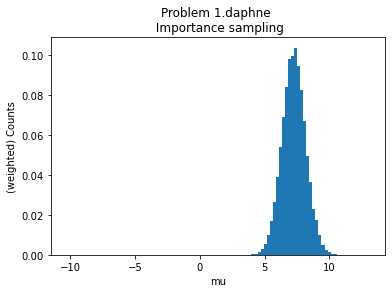

In [60]:
# pd.Series(samples).plot.hist()
_ = plt.hist(samples, weights=probs, bins=100)
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.xlabel('mu')
plt.ylabel('(weighted) Counts')


In [57]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas) 
posterior_variance = expectation_samples_2 - posterior_mean**2

In [58]:
"Importance sampling: posterior mean of mu {:1.3f} | variance {:1.3e}".format(posterior_mean,posterior_variance)

'Importance sampling: posterior mean of mu 7.255 | variance 8.292e-01'

### MH within Gibbs
5k in 5.58s implies 537k samples in 10 min

In [11]:
import mh_gibbs 
from hmc import compute_log_joint_prob
importlib.reload(mh_gibbs)

<module 'mh_gibbs' from '/Users/gw/repos/prob_prog/hw/hw3/mh_gibbs.py'>

In [12]:
fname = '1.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['observe3', 'observe4', 'sample2'],
  'A': {'sample2': ['observe3', 'observe4']},
  'P': {'sample2': ['sample*', ['normal', 1, ['sqrt', 5]]],
   'observe3': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 8],
   'observe4': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 9]},
  'Y': {'observe3': 8, 'observe4': 9}},
 'sample2']

In [13]:
%%time
num_steps=537000
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps=num_steps)

CPU times: user 9min 48s, sys: 2.11 s, total: 9min 51s
Wall time: 9min 54s


In [14]:
samples = np.array([x.item() for x in return_list])

Text(0.5, 0, 'mu')

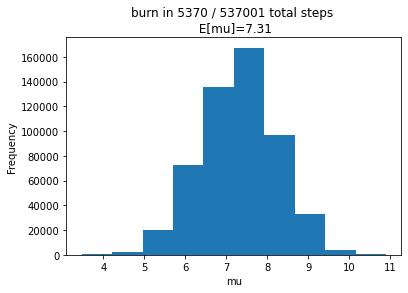

In [15]:
burn_in = int(0.01*num_steps)
sr = pd.Series(samples[burn_in:])
sr.plot.hist()
sr.mean()
plt.title('burn in {:} / {:} total steps \n E[mu]={:1.2f}'.format(burn_in, len(samples),sr.mean()))
plt.xlabel('mu')

In [16]:
"MH Gibbs: posterior mean of mu {:1.3f} | variance {:1.3e}".format(sr.mean(),sr.var())

'MH Gibbs: posterior mean of mu 7.310 | variance 8.421e-01'

Text(0.5, 1.0, '1.daphne | MH Gibbs \n Sample trace')

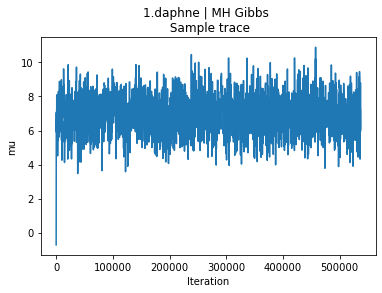

In [17]:
pd.Series(samples).plot()
plt.xlabel('Iteration')
plt.ylabel('mu')
plt.title('{} | MH Gibbs \n Sample trace'.format(fname))

In [18]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [19]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '1.daphne | MH Gibbs \n Joint density')

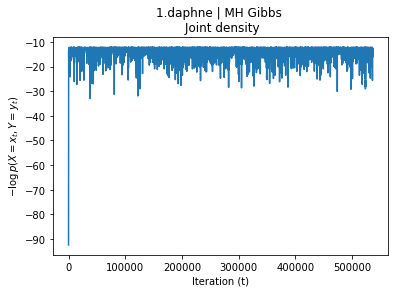

In [20]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | MH Gibbs \n Joint density'.format(fname))

### HMC
5k samples in 41.4 s implies 72k in 10 min

In [61]:
fname = '1.daphne' 
graph = graph_helper(fname)

In [62]:
import hmc
importlib.reload(hmc)
from hmc import hmc_wrapper

In [ ]:
num_samples=72000
return_list, samples_whole_graph = hmc_wrapper(graph,num_samples,T=20,epsilon=0.1)

In [70]:
samples = np.array([x.item() for x in return_list])

Text(0.5, 0, 'mu')

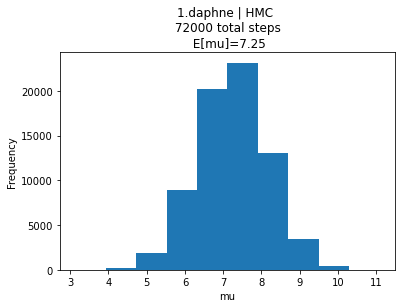

In [71]:
burn_in = int(0.01*num_samples) # ~500 from inspecting joint density plot, with given hyper params T, epsilon, M
sr = pd.Series(samples[burn_in:])
sr.plot.hist()
sr.mean()
plt.title('{} | HMC \n {:} total steps \n E[mu]={:1.2f}'.format(fname,len(samples),sr.mean()))
plt.xlabel('mu')

In [72]:
"HMC: posterior mean of mu {:1.3f} | variance {:1.3e}".format(sr.mean(),sr.var())

'HMC: posterior mean of mu 7.249 | variance 8.324e-01'

Text(0.5, 1.0, '1.daphne | HMC \n Sample trace')

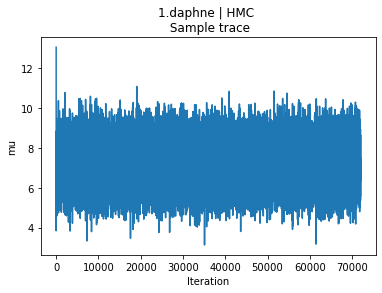

In [73]:
pd.Series(samples).plot()
plt.xlabel('Iteration')
plt.ylabel('mu')
plt.title('{} | HMC \n Sample trace'.format(fname))

In [74]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '1.daphne | HMC \n Joint density')

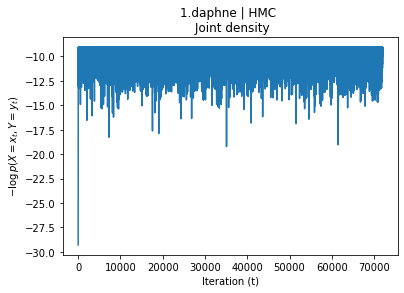

In [75]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | HMC \n Joint density'.format(fname))